In [1]:
import pandas as pd
from birdsong_dataset import AudioDataset

In [2]:
df = pd.read_csv("./data/birdsong_metadata.csv")
df.nunique()

file_id                   264
genus                      66
species                    85
english_cname              88
who_provided_recording     68
country                    18
latitude                  195
longitute                 198
type                       54
license                     4
dtype: int64

In [9]:
import torch
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, name , species = sample[0], sample[1],sample[2]

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))[:, :, :141]
        print(image.shape)
        return torch.from_numpy(image) , torch.from_numpy(name) , torch.from_numpy(species)
    

In [35]:
dataset = AudioDataset(transform = ToTensor(), max_len= 3 , overlapping = 0.5 , noise_reduction=True)

Loading The Data...
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUCTICTON 
NOISE REDUC

In [36]:
dataset[0][0].shape

torch.Size([1, 128, 130])

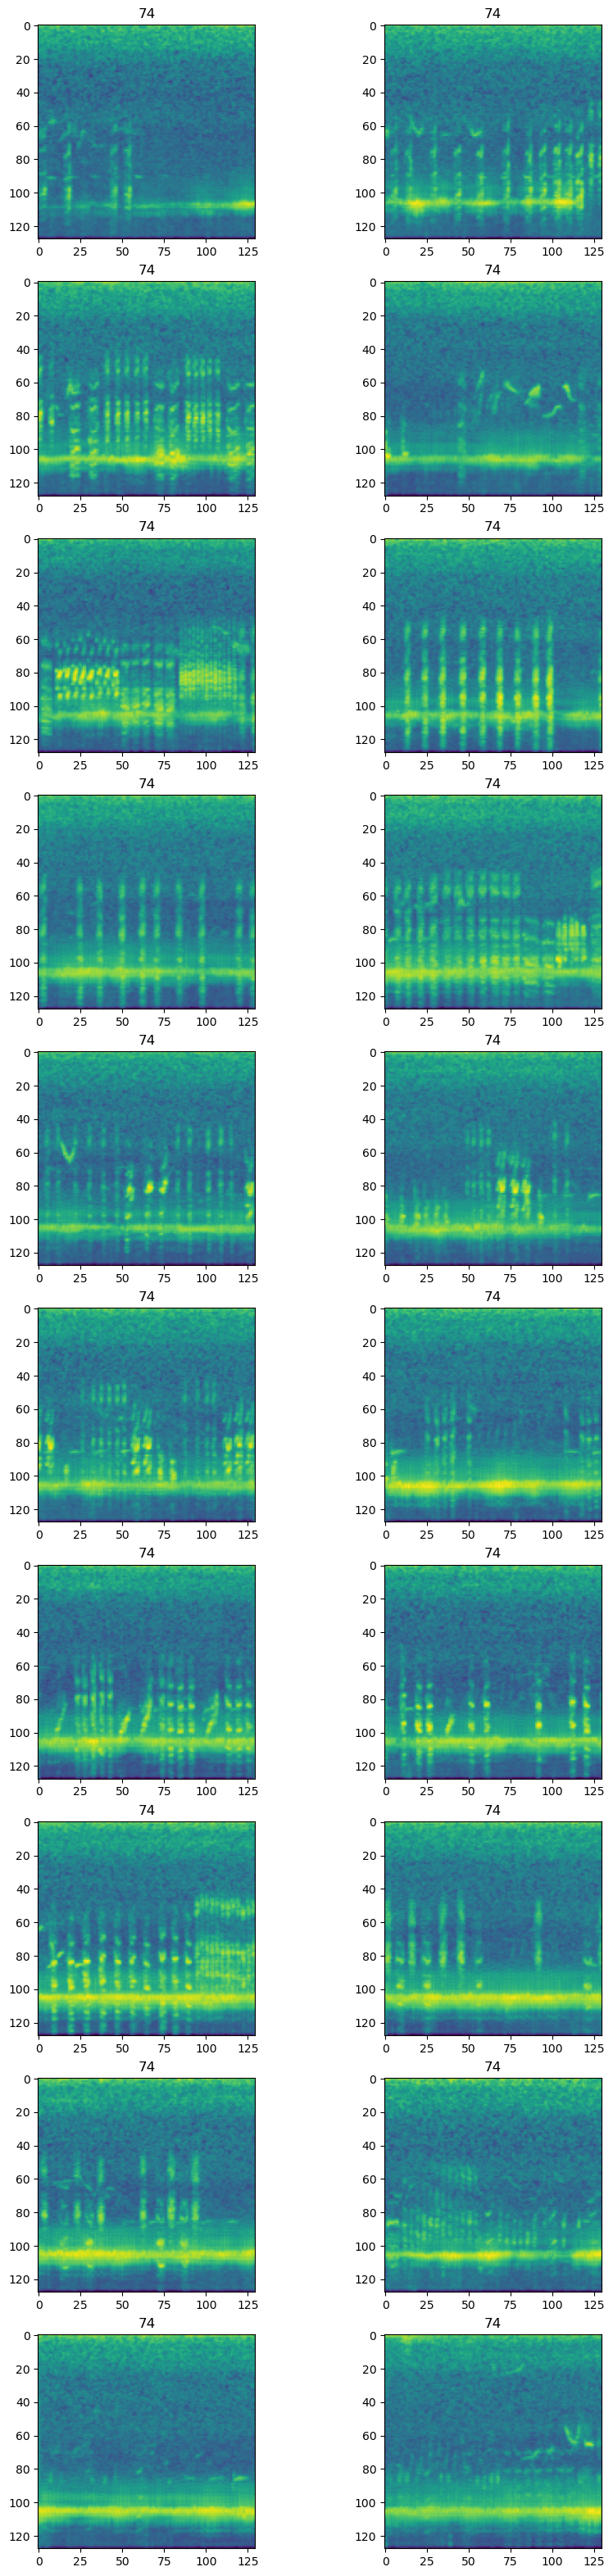

In [44]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,40))
for i in range(20):
    plt.subplot(10,2,i+1)
    plt.title(dataset[i+20][1].item())
    plt.imshow(dataset[i+20][0].to('cpu').numpy().transpose((1,2,0)))

In [41]:
from torch import nn
import torch


class BirdSongClassifier(nn.Module):
    def __init__(self, num_classes_1 = 88 , num_classes_2 = 85):
        super(BirdSongClassifier,self).__init__()
        # backbone
        self.conv1 = nn.Conv2d( in_channels=1, out_channels= 64 , kernel_size=3)
        self.norm1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d((3,3))
        self.conv2 = nn.Conv2d( in_channels=64, out_channels=128 , kernel_size=3)
        self.norm2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d((3,3))
        self.conv3 = nn.Conv2d( in_channels=128, out_channels=64 , kernel_size=3)
        self.norm3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d((3,3))
        
        # multilabel classification for name 
        
        self.names_l1 = nn.Linear(64*3*3 ,512 )
        self.names_relu1 = nn.ReLU()
        self.names_l2 = nn.Linear(512 , num_classes_1 )
        
        # multilabel classification for species       
        
        self.species_l1 = nn.Linear(64*3*3 ,512 )
        self.species_relu1 = nn.ReLU()
        self.species_l2 = nn.Linear(512 , num_classes_2 )
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.norm1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu3(x)
        backbone = self.pool3(x)
        # print("Backbone Shape : ", backbone.size())
        #forward for names
        x1 = backbone.view(-1, 64*3*3)
        x1 = self.names_l1(x1.reshape(-1,64*3*3))
        x1 = self.names_relu1(x1)
        x1 = self.names_l2(x1)
        # print("Name Head Shape = " ,x1.shape)

        #forward for species

        x2 = backbone.view(-1, backbone.size(0) * backbone.size(1) * backbone.size(2) * backbone.size(3))
        x2 = self.species_l1(x2.reshape(-1,backbone.size(0) * backbone.size(1) * backbone.size(2) * backbone.size(3)))
        x2 = self.species_relu1(x2)
        x2 = self.species_l2(x2)
        return x1  ,x2

    def test_model(self, data_loader):
        """
        Test a model on a specified dataset.
    
        Inputs:
            net - Trained model of type BaseNetwork
            data_loader - DataLoader object of the dataset to test on (validation or test)
        """
        self.eval()
        self.to("cuda")
        true_preds_names, true_preds_species,  count = 0., 0.0, 0
        
        for imgs, names , species in data_loader: 
            imgs, names , species = imgs.to("cuda"), names.to("cuda") , species.to("cuda")
            with torch.no_grad():
                preds = self(imgs)
                preds_names = preds[0].argmax(dim=-1)
                preds_species = preds[1].argmax(dim=-1)
                true_preds_names += (preds_names == names )[0].sum().item()
                true_preds_species += (preds_species == species )[0].sum().item()
                count += 2
        test_acc = (true_preds_names +  true_preds_species) / count
        return test_acc
model = BirdSongClassifier()
        

In [42]:
from torch.utils.data import random_split, DataLoader


indices = torch.randperm(len(dataset))

# Define the sizes of your desired splits
train_size = int(0.6 * len(dataset))  # 60% of the data for training
val_size = int(0.25 * len(dataset))   # 25% of the data for validation
test_size = len(dataset) - train_size - val_size  # Remaining data for testing

# Use random_split with shuffled indices to create the splits
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

batch_size = 1
# You can then create data loaders for each split if needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, )
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

model.test_model( test_loader )

0.009029345372460496

In [43]:
 import time
from torch import optim



# Define loss function and optimizer
criterion_names = nn.CrossEntropyLoss()
criterion_species = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.00001)
model.to("cuda")
# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels_names, labels_species) in enumerate(train_loader):
        
        labels_names , labels_species = labels_names.to("cuda") , labels_species.to("cuda")
        optimizer.zero_grad()
        # Forward pass
        outputs_names , outputs_species = model(inputs.type(torch.cuda.FloatTensor))
        # print(torch.argmax(outputs_names , dim=-1).item(), labels_names.item() ,"-------", torch.argmax(outputs_species , dim=-1).item(), labels_species.item())
        # time.sleep(0.1)
        
        # Calculate loss
        loss_names = criterion_names(outputs_names, labels_names.type(torch.cuda.LongTensor) )
        loss_species = criterion_species(outputs_species, labels_species.type(torch.cuda.LongTensor))
        t_loss_names = loss_names 
        t_loss_species = loss_species
        total_loss = loss_names + loss_species
        # Backward pass
        total_loss.backward()
        # t_loss_species.backward(retain_graph= True)
        # Update weights
        optimizer.step()
        # optimizer_species.step()
        running_loss += total_loss.item()
        # running_loss_species += t_loss_species.item()
        
        # Print statistics every 100 batches
    if (epoch + 1) % 1 == 0:
        train_acc = model.test_model(train_loader) 
        val_acc = model.test_model(val_loader)
        
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss : {running_loss :.6f} , Train Acc : {train_acc:.4f}, Val Acc : {val_acc:.8f}')
    

print('Finished Training')

Epoch [1/1000], Training Loss : 15976.719915 , Train Acc : 0.0068, Val Acc : 0.00813008
Epoch [2/1000], Training Loss : 15861.057656 , Train Acc : 0.0071, Val Acc : 0.01151762
Epoch [3/1000], Training Loss : 15764.471343 , Train Acc : 0.0127, Val Acc : 0.01626016
Epoch [4/1000], Training Loss : 15671.182718 , Train Acc : 0.0181, Val Acc : 0.01558266
Epoch [5/1000], Training Loss : 15581.333811 , Train Acc : 0.0277, Val Acc : 0.02642276
Epoch [6/1000], Training Loss : 15499.288495 , Train Acc : 0.0347, Val Acc : 0.03387534
Epoch [7/1000], Training Loss : 15423.148681 , Train Acc : 0.0404, Val Acc : 0.04268293
Epoch [8/1000], Training Loss : 15347.503987 , Train Acc : 0.0466, Val Acc : 0.04471545
Epoch [9/1000], Training Loss : 15278.855795 , Train Acc : 0.0517, Val Acc : 0.05216802
Epoch [10/1000], Training Loss : 15212.852437 , Train Acc : 0.0559, Val Acc : 0.05013550
Epoch [11/1000], Training Loss : 15151.205205 , Train Acc : 0.0584, Val Acc : 0.05216802
Epoch [12/1000], Training Loss

KeyboardInterrupt: 

In [18]:
torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, "epoch_1000_ta_79_va_67.pt")


In [22]:
device = torch.device("cuda")
model_ft = BirdSongClassifier()
optimizer_ft = optim.SGD(model.parameters(), lr=0.00001)

checkpoint = torch.load("epoch_1000_ta_79_va_67.pt" , map_location= device)
model_ft.load_state_dict(checkpoint['model_state_dict'])
optimizer_ft.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
model_ft.to(device)

BirdSongClassifier(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  (names_l1): Linear(in_features=768, out_features=512, bias=True)
  (names_relu1): ReLU()
  (names_l2): Linear(in_features=512, out_features=88, bias=True)
  (species_l1): Linear(

In [23]:
num_epochs = 1000
for epoch in range(num_epochs):
    model_ft.train()
    running_loss = 0.0
    for i, (inputs, labels_names, labels_species) in enumerate(train_loader):
        
        labels_names , labels_species = labels_names.to("cuda") , labels_species.to("cuda")
        optimizer.zero_grad()
        # Forward pass
        outputs_names , outputs_species = model_ft(inputs.type(torch.cuda.FloatTensor))
        # print(torch.argmax(outputs_names , dim=-1).item(), labels_names.item() ,"-------", torch.argmax(outputs_species , dim=-1).item(), labels_species.item())
        # time.sleep(0.1)
        
        # Calculate loss
        loss_names = criterion_names(outputs_names, labels_names.type(torch.cuda.LongTensor) )
        loss_species = criterion_species(outputs_species, labels_species.type(torch.cuda.LongTensor))
        t_loss_names = loss_names 
        t_loss_species = loss_species
        total_loss = loss_names + loss_species
        # Backward pass
        total_loss.backward()
        # t_loss_species.backward(retain_graph= True)
        # Update weights
        optimizer.step()
        # optimizer_species.step()
        running_loss += total_loss.item()
        # running_loss_species += t_loss_species.item()
        
        # Print statistics every 100 batches
    if (epoch + 1) % 1 == 0:
        train_acc = model_ft.test_model(train_loader) 
        val_acc = model_ft.test_model(val_loader)
        
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss : {running_loss :.6f} , Train Acc : {train_acc:.4f}, Val Acc : {val_acc:.8f}')
    

print('Finished Training')

Epoch [1/1000], Training Loss : 1561.648120 , Train Acc : 0.8114, Val Acc : 0.69710145
Epoch [2/1000], Training Loss : 1564.701713 , Train Acc : 0.8271, Val Acc : 0.69565217
Epoch [3/1000], Training Loss : 1572.912654 , Train Acc : 0.8204, Val Acc : 0.68115942
Epoch [4/1000], Training Loss : 1566.559977 , Train Acc : 0.8295, Val Acc : 0.69130435
Epoch [5/1000], Training Loss : 1568.844399 , Train Acc : 0.8126, Val Acc : 0.68405797
Epoch [6/1000], Training Loss : 1569.589457 , Train Acc : 0.8222, Val Acc : 0.71739130
Epoch [7/1000], Training Loss : 1573.738139 , Train Acc : 0.8035, Val Acc : 0.70869565
Epoch [8/1000], Training Loss : 1571.554301 , Train Acc : 0.8235, Val Acc : 0.67101449
Epoch [9/1000], Training Loss : 1572.467697 , Train Acc : 0.8047, Val Acc : 0.69420290
Epoch [10/1000], Training Loss : 1570.607854 , Train Acc : 0.8265, Val Acc : 0.65797101
Epoch [11/1000], Training Loss : 1573.262043 , Train Acc : 0.8253, Val Acc : 0.70724638
Epoch [12/1000], Training Loss : 1568.076

KeyboardInterrupt: 